# Speech Command Recognition 

## Import needed modules

In [1]:
import tensorflow as tf
import librosa
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import SpeechDownloader
import AudioGen
import speech_model


## Download data from google speech command dataset

In [50]:
gscInfo, nCategs = SpeechDownloader.PrepareGoogleSpeechCmd(version=2, task='35word')

0it [00:00, ?it/s]

Google Speech commands dataset version 2 already exists. Skipping download.
Converting test set WAVs to numpy files
Converting training set WAVs to numpy files



0it [00:00, ?it/s]


Done preparing Google Speech commands dataset version 2


# Audio Generator

In [3]:
#the default sampling rate for google speech command dataset
sr = 16000
iLen = sr
#We have four sets of dataset: train/val/test/testReal, in which train/val/test are used for training process
#and testReal is used for testing.

#As a result, we need to define 4 generator respectively for each set of data.
trainGen = AudioGen.AudioGen(gscInfo['train']['files'], gscInfo['train']['labels'], shuffle=True)
valGen   = AudioGen.AudioGen(gscInfo['val']['files'], gscInfo['val']['labels'], shuffle=True)
testGen  = AudioGen.AudioGen(gscInfo['test']['files'], gscInfo['test']['labels'], shuffle=False, batch_size=len(gscInfo['test']['files']))
testRGen = AudioGen.AudioGen(gscInfo['testREAL']['files'], gscInfo['testREAL']['labels'], shuffle=False, batch_size=len(gscInfo['testREAL']['files']))

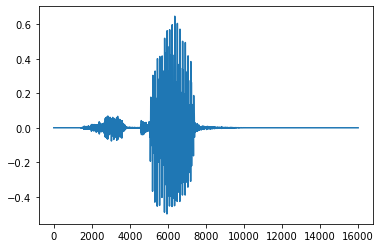

In [4]:
#The __getitem__ method in AudioGen is used to get a batch(32) of data
#The following code is used for check whether the generator works fine
audios_train, classes_train = trainGen.__getitem__(10)
audios_test, classes_test = testGen.__getitem__(15)
classes_train
plt.plot(audios_train[5])

In [5]:
#Before we define our model, we need to test whether our pre-processing of audios works fine.
#To test it, we create a model with keras with two simple layers: 
#One melspectrogram layer and one normalization2D layer. 

from tensorflow.keras.models import Sequential
from spela.melspectrogram import Melspectrogram
from spela.normalisation import Normalization2D
import numpy as np
import soundfile as sf
from scipy.fftpack import dct
import math
import os
import matplotlib as mpl
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Lambda
import tensorflow.keras.layers

melspecModel = Sequential()
melspecModel.add(Melspectrogram(n_dft=512, n_hop=128, input_shape=(1, iLen),
                         padding='same', sr=sr, n_mels=80,
                         fmin=40.0, fmax=sr/2, power_melgram=1.0,
                         return_decibel_melgram=True, trainable_fb=False,
                         trainable_kernel=False,
                         name='mel_stft') )
melspecModel.add(Normalization2D(int_axis=0))
melspecModel.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mel_stft (Melspectrogram)    (None, 80, 125, 1)        283728    
_________________________________________________________________
normalization2d (Normalizati (None, 80, 125, 1)        0         
Total params: 283,728
Trainable params: 283,728
Non-trainable params: 0
_________________________________________________________________


In [6]:
melspec = melspecModel.predict(audios_train.reshape((-1,1,iLen)) )
melspec.shape

(32, 80, 125, 1)

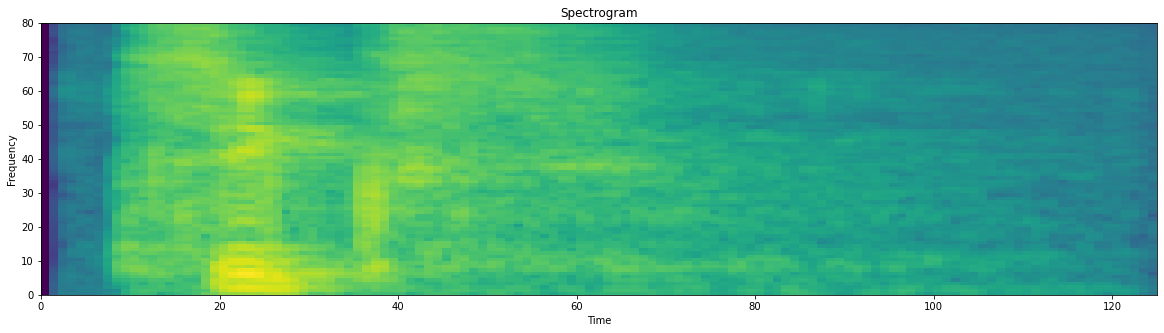

In [7]:
plt.figure(figsize=(20,5))
plt.pcolormesh(melspec[4,:,:,0])

plt.title('Spectrogram')
plt.xlabel('Time')
plt.ylabel('Frequency')

plt.show()

# Models

Create Keras models to see if the generators are working properly

In [8]:
import math
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler, ReduceLROnPlateau
from adjust_utils import *

In [10]:
model_e = speech_model.att_rnn_model(nCategs, samplingrate = sr, inputLength = None)
model_e.compile(optimizer='adam', loss=['sparse_categorical_crossentropy'], metrics=['sparse_categorical_accuracy'])
model_e.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, None)]       0                                            
__________________________________________________________________________________________________
reshape_1 (Reshape)             (None, 1, None)      0           input[0][0]                      
__________________________________________________________________________________________________
Mel_Spec (Melspectrogram)       (None, 80, None, 1)  1091664     reshape_1[0][0]                  
__________________________________________________________________________________________________
Mel_Spec_Norm (Normalization2D) (None, 80, None, 1)  0           Mel_Spec[0][0]                   
____________________________________________________________________________________________

In [11]:
lr_exp = LearningRateScheduler(exp_decay)

earlystopper = EarlyStopping(monitor='val_sparse_categorical_accuracy', patience=10, verbose=1, restore_best_weights=True)

cp_e = ModelCheckpoint(filepath='model_attRNN_e.h5', monitor='val_sparse_categorical_accuracy', verbose=1, save_best_only=True)

results_e = model_e.fit(trainGen, validation_data=valGen, epochs=60, use_multiprocessing=False, workers=4, verbose=2,
                    callbacks=[earlystopper, cp_e, lr_exp])

model_e.save('model_attRNN_e.h5')

Changing learning rate to 0.0019952623149688794
Epoch 1/60

Epoch 00001: val_sparse_categorical_accuracy improved from -inf to 0.89429, saving model to model_attRNN_e.h5
3317/3317 - 831s - loss: 0.6613 - sparse_categorical_accuracy: 0.8123 - val_loss: 0.3698 - val_sparse_categorical_accuracy: 0.8943 - lr: 0.0020
Changing learning rate to 4e-05
Epoch 2/60

Epoch 00002: val_sparse_categorical_accuracy improved from 0.89429 to 0.93589, saving model to model_attRNN_e.h5
3317/3317 - 863s - loss: 0.2636 - sparse_categorical_accuracy: 0.9269 - val_loss: 0.2373 - val_sparse_categorical_accuracy: 0.9359 - lr: 4.0000e-05
Changing learning rate to 4e-05
Epoch 3/60

Epoch 00003: val_sparse_categorical_accuracy improved from 0.93589 to 0.93720, saving model to model_attRNN_e.h5
3317/3317 - 830s - loss: 0.2297 - sparse_categorical_accuracy: 0.9366 - val_loss: 0.2277 - val_sparse_categorical_accuracy: 0.9372 - lr: 4.0000e-05
Changing learning rate to 4e-05
Epoch 4/60

Epoch 00004: val_sparse_categori

Changing learning rate to 4e-05
Epoch 30/60

Epoch 00030: val_sparse_categorical_accuracy did not improve from 0.94946
3317/3317 - 824s - loss: 0.1000 - sparse_categorical_accuracy: 0.9768 - val_loss: 0.2062 - val_sparse_categorical_accuracy: 0.9488 - lr: 4.0000e-05
Changing learning rate to 4e-05
Epoch 31/60

Epoch 00031: val_sparse_categorical_accuracy did not improve from 0.94946
3317/3317 - 826s - loss: 0.0985 - sparse_categorical_accuracy: 0.9773 - val_loss: 0.2094 - val_sparse_categorical_accuracy: 0.9480 - lr: 4.0000e-05
Changing learning rate to 4e-05
Epoch 32/60

Epoch 00032: val_sparse_categorical_accuracy did not improve from 0.94946
3317/3317 - 828s - loss: 0.0978 - sparse_categorical_accuracy: 0.9776 - val_loss: 0.2070 - val_sparse_categorical_accuracy: 0.9477 - lr: 4.0000e-05
Changing learning rate to 4e-05
Epoch 33/60

Epoch 00033: val_sparse_categorical_accuracy did not improve from 0.94946
3317/3317 - 829s - loss: 0.0952 - sparse_categorical_accuracy: 0.9781 - val_loss

KeyboardInterrupt: 

In [ ]:
# summarize history for categorical accuracy
plt.plot(results.history['sparse_categorical_accuracy'])
plt.plot(results.history['val_sparse_categorical_accuracy'])
plt.title('Categorical accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [54]:
# load best model according to cross-validation - model-attRNN
model = load_model('model_attRNN_e.h5', custom_objects={'Melspectrogram': Melspectrogram, 'Normalization2D': Normalization2D })
# model.load_weights('model-attRNN.h5')

In [36]:
#read all test data
x_test, y_test = testGen.__getitem__(0)

In [55]:
valEval = model.evaluate(valGen, use_multiprocessing=False, workers=4,verbose=0)
trainEval = model.evaluate(trainGen, use_multiprocessing=False, workers=4,verbose=0)
testEval = model.evaluate(x_test, y_test, verbose=0)
print('Evaluation scores: \nMetrics: {} \nTrain: {} \nValidation: {} \nTest: {}'.format(model_e.metrics_names, trainEval, valEval, testEval) )

Evaluation scores: 
Metrics: ['loss', 'sparse_categorical_accuracy'] 
Train: [0.05674492567777634, 0.9867444038391113] 
Validation: [0.18921203911304474, 0.9573954939842224] 
Test: [0.172851100564003, 0.9537482857704163]


In [25]:
kaggle12cmd = False
if kaggle12cmd:
    #only for the Kaggle competition, 12-cmd
    x_testR, y_testR = testRGen.__getitem__(0)
    testREval = model.evaluate(x_testR, y_testR, verbose=1)
    print(testREval)
    testREval = model.evaluate(testRGen, use_multiprocessing=True, workers=4,verbose=1)
    print(testREval)

## Evaluation and Attention Plots

In [38]:
from tensorflow.keras.models import Model, load_model

In [39]:
attSpeechModel = Model(inputs=model.input,
                       outputs=[model.get_layer('output').output,
                       model.get_layer('Att_weighted_Softmax').output,
                       model.get_layer('Mel_Spec').output])

In [40]:
audios, classes = valGen.__getitem__(3)
classes

array([10, 22, 32, 11,  9,  7,  6, 12, 19, 12, 29, 18, 17, 11, 17, 32, 10,
       11,  3, 17, 29, 23,  9,  4, 20, 26, 16, 14,  5,  1,  7,  3])

In [41]:
#8 - on, 13 - one, 7 - right
idAudio = 8
classes[idAudio]

19

In [42]:
outs, attW, specs = attSpeechModel.predict(audios)

In [43]:
np.argmax(outs,axis=1)

array([10, 22, 32, 11,  9,  7,  6, 12, 19, 34, 29, 18, 17, 22, 26, 32, 10,
       11,  3, 17, 29, 23,  9,  4, 20, 26, 16, 14,  5,  1,  7,  1])

In [44]:
specs.shape

(32, 80, 125, 1)

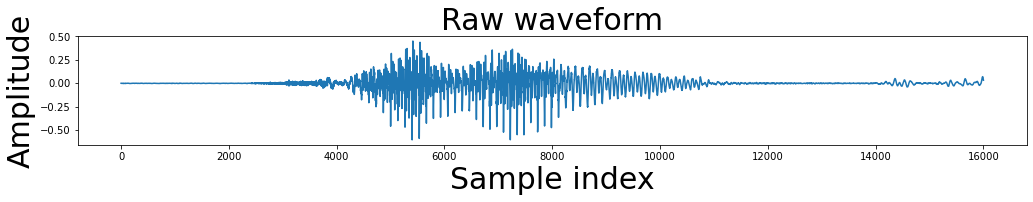

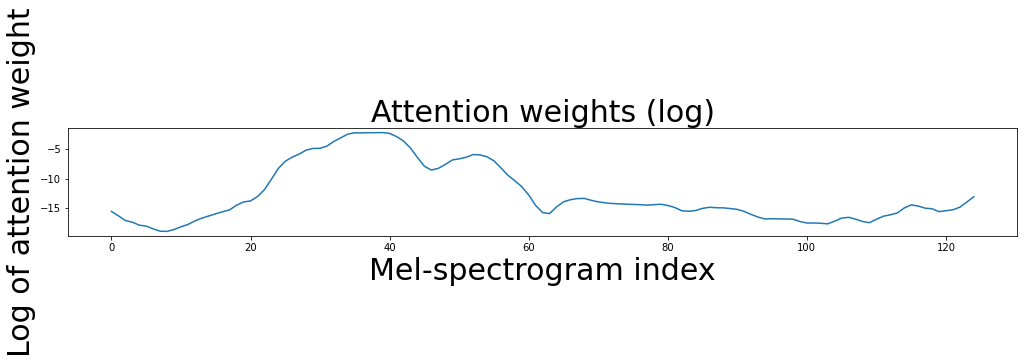

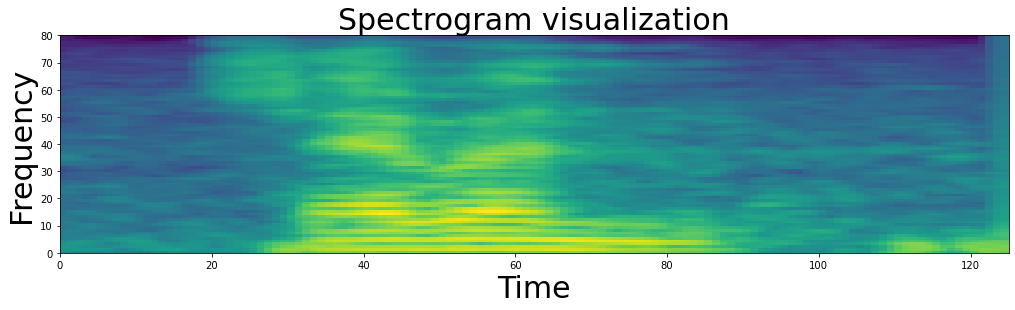

In [45]:
imgHeight = 2

plt.figure(figsize=(17,imgHeight))
plt.title('Raw waveform', fontsize=30)
plt.ylabel('Amplitude', fontsize=30)
plt.xlabel('Sample index', fontsize=30)
plt.plot(audios[idAudio])
plt.savefig('picrawWave.png', dpi = 400)
plt.show()

plt.figure(figsize=(17,imgHeight))
plt.title('Attention weights (log)', fontsize=30)
plt.ylabel('Log of attention weight', fontsize=30)
plt.xlabel('Mel-spectrogram index', fontsize=30)
plt.plot(np.log(attW[idAudio]))
plt.savefig('picAttention.png', dpi = 400)
plt.show()


plt.figure(figsize=(17,imgHeight*2))
plt.pcolormesh(specs[idAudio,:,:,0])

plt.title('Spectrogram visualization', fontsize=30)
plt.ylabel('Frequency', fontsize=30)
plt.xlabel('Time', fontsize=30)
plt.savefig('picmelSpec.png', dpi = 400)

plt.show()

In [46]:
y_pred = model.predict(x_test, verbose=1)

344/344 [==============================] - 30s 87ms/step


In [47]:
from sklearn.metrics import confusion_matrix
import audioUtils
cm = confusion_matrix(y_test, np.argmax(y_pred,1))

In [48]:
#35word, v2
classes = ['nine', 'yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go',
           'zero', 'one', 'two', 'three', 'four', 'five', 'six', 
           'seven',  'eight', 'backward', 'bed', 'bird', 'cat', 'dog',
           'follow', 'forward', 'happy', 'house', 'learn', 'marvin', 'sheila', 'tree',
           'visual', 'wow']

No Normalization


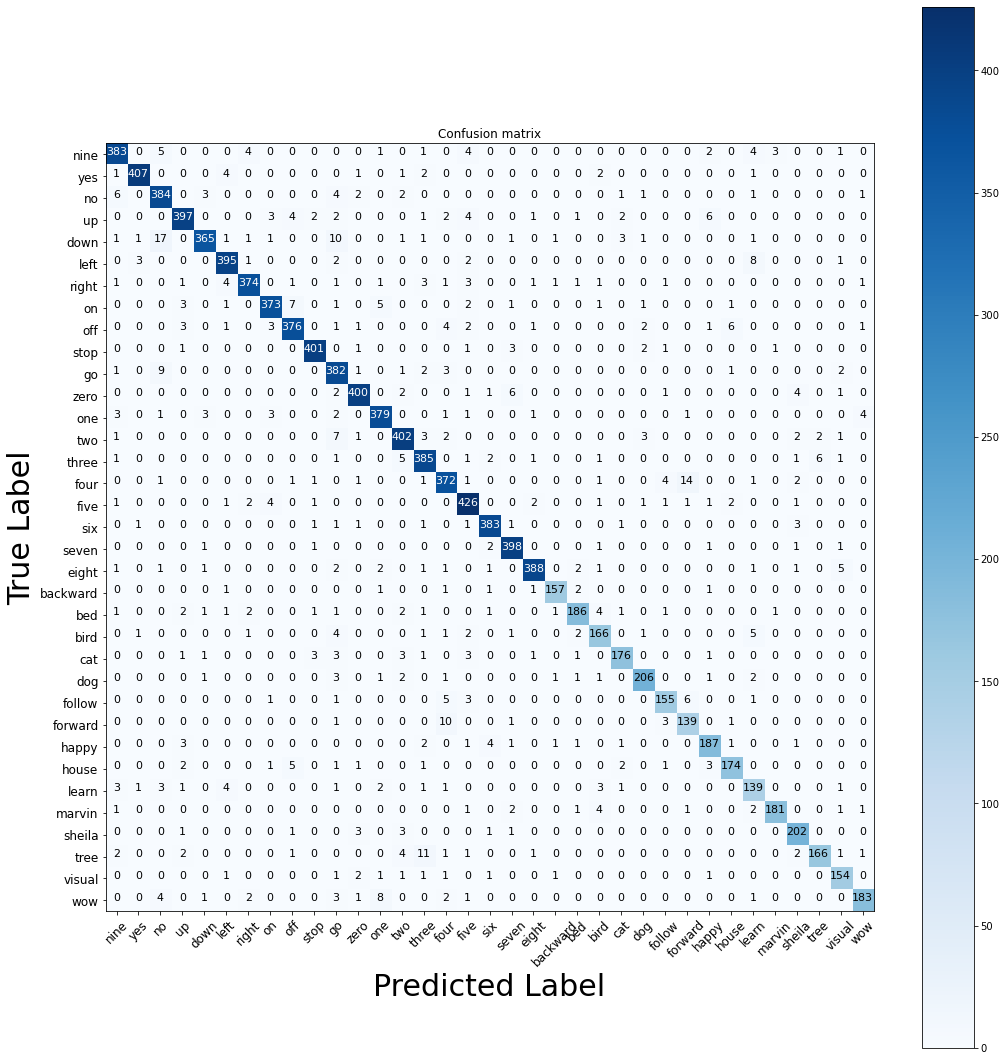

In [49]:
audioUtils.plot_confusion_matrix(cm, classes, normalize=False)